In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from models import AE, VAE
from trainers import AETrainer, VAETrainer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Task 1

In [3]:
df_identity = pd.read_csv('data/task1/data_identity.csv')
df_transaction = pd.read_csv('data/task1/data_transaction.csv')

In [4]:
df = pd.merge(df_identity, df_transaction, on='TransactionID')

In [5]:
labeled_df = df.select_dtypes(exclude=['float64', 'int64', 'int32']).apply(
    lambda series: pd.Series(LabelEncoder().fit_transform(series[series.notnull()]), index=series[series.notnull()].index))

df[labeled_df.columns] = labeled_df

In [6]:
x = torch.torch.from_numpy(df.values).to(torch.float32)

In [7]:
model = AE

ae_trainer = AETrainer(x, model, regularization=False)
ae_trainer_reg = AETrainer(x, model, regularization=True)

D:\work\Projects\Programming\PythonProjects\UniverInnopolis\ML\AML\Assignments\AML-Generative-Models\trainers.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data)


In [8]:
ae_trainer.train(train_epochs=321, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 13998835.053097345 test_loss: 12308769.0
epoch 20 train_loss: 299948.12119745574 test_loss: 276141.0625
epoch 40 train_loss: 8900.946211283186 test_loss: 8326.0927734375
epoch 60 train_loss: 378.1182652363735 test_loss: 383.7254638671875
epoch 80 train_loss: 35.11177873453208 test_loss: 34.62373733520508
epoch 100 train_loss: 3.328432225020586 test_loss: 2.526062250137329
epoch 120 train_loss: 1.7579775372173934 test_loss: 1.715214490890503
epoch 140 train_loss: 1.043412799460698 test_loss: 1.520031452178955
epoch 160 train_loss: 0.6386018300478438 test_loss: 1.3600671291351318
epoch 180 train_loss: 0.4249212402949291 test_loss: 1.219080924987793
epoch 200 train_loss: 0.3258544375411177 test_loss: 1.1069629192352295
epoch 220 train_loss: 0.28443104951782566 test_loss: 1.0181902647018433
epoch 240 train_loss: 0.2716734075704507 test_loss: 0.9707791209220886
epoch 260 train_loss: 0.26898318318139136 test_loss: 0.9390093684196472
epoch 280 train_loss: 0.268923793878175

In [9]:
ae_trainer_reg.train(train_epochs=321, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 12081291.35840708 test_loss: 10515459.0
epoch 20 train_loss: 151905.01690403762 test_loss: 139147.3125
epoch 40 train_loss: 5569.171842591953 test_loss: 5185.205078125
epoch 60 train_loss: 292.85376044079266 test_loss: 274.0442199707031
epoch 80 train_loss: 0.6528190139648133 test_loss: 0.6186853051185608
epoch 100 train_loss: 0.27026903497434296 test_loss: 0.2665603756904602
epoch 120 train_loss: 0.25953714298990976 test_loss: 0.25954216718673706
epoch 140 train_loss: 0.2569842736805435 test_loss: 0.2570088505744934
epoch 160 train_loss: 0.25381697602240383 test_loss: 0.25386881828308105
epoch 180 train_loss: 0.24980462447995633 test_loss: 0.24981087446212769
epoch 200 train_loss: 0.24492863176670748 test_loss: 0.24492226541042328
epoch 220 train_loss: 0.23962735081404712 test_loss: 0.2396172732114792
epoch 240 train_loss: 0.23415724557321682 test_loss: 0.2341257929801941
epoch 260 train_loss: 0.22849530700297482 test_loss: 0.22846631705760956
epoch 280 train_loss:

In [18]:
vae_model = VAE

vae_trainer = VAETrainer(x, vae_model)

In [19]:
vae_trainer.train(train_epochs=201, batch_size=512, verbose_time=20, lr=1e-6)

epoch 0 train_loss: 0.24725543298816258 test_loss: 2.0070143374026342e+17
epoch 20 train_loss: 0.22029518771224318 test_loss: inf
epoch 40 train_loss: 0.1696813053789392 test_loss: 0.7974963188171387
epoch 60 train_loss: 0.10540139952064616 test_loss: inf
epoch 80 train_loss: 0.048651575712503586 test_loss: inf
epoch 100 train_loss: 0.019485844546450977 test_loss: 0.029226981103420258
epoch 120 train_loss: 0.011712126137144797 test_loss: inf
epoch 140 train_loss: 0.00918561342559689 test_loss: 0.011158485896885395
epoch 160 train_loss: 0.007849466286401832 test_loss: 763839296.0
epoch 180 train_loss: 0.006909977523115488 test_loss: 5.790513353990777e+21
epoch 200 train_loss: 0.006159187455257747 test_loss: 0.006373328156769276


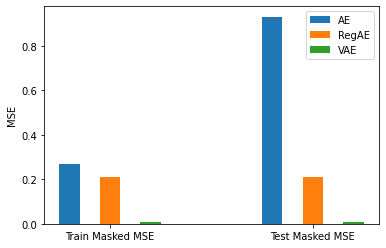

In [20]:
X = ['Train Masked MSE','Test Masked MSE']
ae_best = np.argmin(ae_trainer.history['test_loss'])
ae = [ae_trainer.history['train_loss'][ae_best], ae_trainer.history['test_loss'][ae_best]]

ae_reg_best = np.argmin(ae_trainer_reg.history['test_loss'])
ae_reg = [ae_trainer_reg.history['train_loss'][ae_reg_best], ae_trainer_reg.history['test_loss'][ae_reg_best]]

vae_best = np.argmin(vae_trainer.history['test_loss'])
vae = [vae_trainer.history['train_loss'][vae_best], vae_trainer.history['test_loss'][vae_best]]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, ae, 0.1, label = 'AE')
plt.bar(X_axis, ae_reg, 0.1, label = 'RegAE')
plt.bar(X_axis + 0.2, vae, 0.1, label = 'VAE')

plt.xticks(X_axis, X)
plt.ylabel("MSE")
plt.legend()
plt.show()

# Task 2

In [21]:
df2 = pd.read_csv('data/task2/UNSW_NB15_training-set.csv')